In [2]:
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point
from itertools import combinations
import heapq


import contextily as cx
import matplotlib.pyplot as plt


import requests
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Point, Polygon, MultiPolygon, box
from matplotlib.colors import ListedColormap

from matplotlib_scalebar.scalebar import ScaleBar


In [3]:
folder_progetto="D:\\database_vari_miei\\progettoponte\\"

## carica punti strade e ponte

In [4]:
punti_ponte=[str(x) for x in [1086,1087,66,1088,1089,65,1090,11,64,1091,10,1095,1092]]
punti_scalette=[str(x) for x in [935,936,937,938,939,934,933,940]]

In [5]:
gdf=gpd.read_file(f"{folder_progetto}puntistradenuovo.geojson")
#gdf=gdf.sample(frac=0.9,random_state=10)
gdf.reset_index(inplace=True,drop=True)
gdf["id_punto"]=["punto_strada_"+str(x) for x in gdf.index.values]
nomi_nuovi=gdf.loc[gdf["id_punto"].apply(lambda x:x.split("_")[-1]).isin(punti_ponte),"id_punto"].str.replace("strada","ponte").values
gdf.loc[gdf["id_punto"].apply(lambda x:x.split("_")[-1]).isin(punti_ponte),"id_punto"]=nomi_nuovi

nomi_nuovi=gdf.loc[gdf["id_punto"].apply(lambda x:x.split("_")[-1]).isin(punti_scalette),"id_punto"].str.replace("strada","scalette").values
gdf.loc[gdf["id_punto"].apply(lambda x:x.split("_")[-1]).isin(punti_scalette),"id_punto"]=punti_scalette

## crea il grafo delle strade

In [6]:
%%time
# Create a graph
G = nx.Graph()


# Add nodes to the graph
for index, row in gdf.iterrows():
    G.add_node(row['id_punto'], pos=(row['geometry'].x, row['geometry'].y))

# Create a priority queue for each node's neighbors
node_neighbors = {node: [] for node in G.nodes}

# Add edges to the graph based on closest points and their distances
for (id1, data1), (id2, data2) in combinations(G.nodes(data=True), 2):
    pos1 = data1['pos']
    pos2 = data2['pos']
    distance = Point(pos1).distance(Point(pos2))
    
    # Add the pair to the priority queues
    heapq.heappush(node_neighbors[id1], (distance, id2))
    heapq.heappush(node_neighbors[id2], (distance, id1))

# Add edges to the graph for the two closest neighbors for each node
for node, neighbors in node_neighbors.items():
    for _, neighbor in heapq.nsmallest(5, neighbors):
        G.add_edge(node, neighbor, weight=_)
        
# nx.draw(G, pos, with_labels=True, font_weight='bold')

Wall time: 42 s


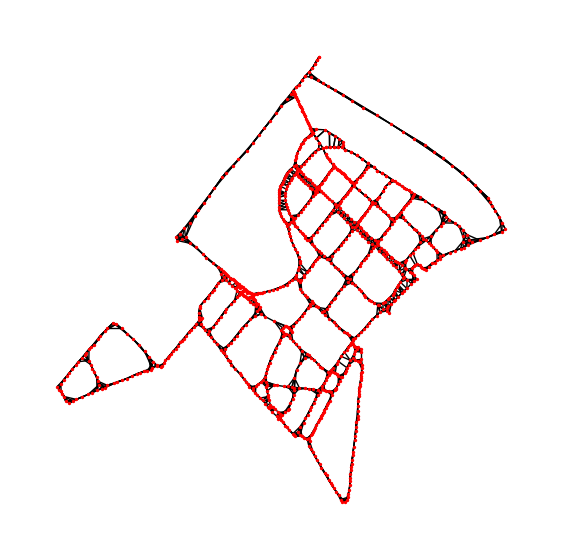

In [7]:
fig,axs=plt.subplots(figsize=(7,7))
positions=nx.get_node_attributes(G,"pos")
nx.draw(G, positions, node_color='red',node_size=2,edge_color="black",ax=axs)
#puntiaccesso.plot(ax=axs,color="green")

# recupera le posizioni dei palazzzi e crea i "punti di accesso" alle strade

In [8]:

# Define the bounding box of your rectangle in EPSG:3857
xmin, xmax, ymin, ymax = 1393520.467913213, 1395363.8859653217, 5150355.742469572, 5152336.79184508

# Convert coordinates to EPSG:4326 (WGS84)
bbox = box(xmin, ymin, xmax, ymax)
bbox_wgs84 = gpd.GeoSeries(bbox, crs='EPSG:3857').to_crs('EPSG:4326').total_bounds

# Formulate an Overpass API query to retrieve buildings within the bounding box
overpass_query = f"""
    [out:json];
    (
        way["building"]({bbox_wgs84[1]},{bbox_wgs84[0]},{bbox_wgs84[3]},{bbox_wgs84[2]});
        relation["building"]({bbox_wgs84[1]},{bbox_wgs84[0]},{bbox_wgs84[3]},{bbox_wgs84[2]});
    );
    out geom;
"""

# Define the Overpass API endpoint
overpass_url = "https://overpass-api.de/api/interpreter"

response=requests.post(overpass_url, data=overpass_query)

lista_finale=[]
risposte=response.json()["elements"]
# List of coordinates
for geometria in risposte:
    
    try:
        coordinates = geometria["geometry"]
        lon_lat_coordinates = [(coord['lon'], coord['lat']) for coord in coordinates]
        # Create a Shapely Polygon
        final_polygon = Polygon(lon_lat_coordinates)
        multi_polygon = MultiPolygon([final_polygon])

    except:
        final_polygon=[]
        for geom in geometria["members"]:
            coordinates = geom["geometry"]
            lon_lat_coordinates = [(coord['lon'], coord['lat']) for coord in coordinates]
            # Create a Shapely Polygon
            final_polygon.append(Polygon(lon_lat_coordinates))
        multi_polygon=MultiPolygon(final_polygon)
            # Create a list of (lon, lat) tuples
    #print("dae")
    lista_finale.append(multi_polygon)
palazzi=gpd.GeoDataFrame({"geometry":lista_finale})
palazzi.set_crs("EPSG:4326",inplace=True)
palazzi["id_palazzo"]=palazzi.index.values
palazzi.to_crs("EPSG:3857")

,geometry,id_palazzo
0,"MULTIPOLYGON (((1394451.383 5150359.625, 13944...",0
1,"MULTIPOLYGON (((1394024.406 5152378.507, 13940...",1
2,"MULTIPOLYGON (((1393586.464 5150588.859, 13936...",2
3,"MULTIPOLYGON (((1394115.944 5150954.372, 13941...",3
4,"MULTIPOLYGON (((1394100.003 5151007.329, 13941...",4
...,...,...
815,"MULTIPOLYGON (((1395142.532 5152051.804, 13951...",815
816,"MULTIPOLYGON (((1395306.695 5152295.446, 13953...",816
817,"MULTIPOLYGON (((1395220.723 5152097.374, 13952...",817
818,"MULTIPOLYGON (((1395326.922 5151785.512, 13953...",818


# aggiungi punti accesso al grafo

In [9]:
# puntiaccesso=gpd.read_file(f"{folder_progetto}puntiaccessostrada.geojson")
puntiaccesso=gpd.GeoDataFrame({"geometry":palazzi.geometry.centroid}).to_crs("EPSG:3857")
puntiaccesso["id_palazzo"]=puntiaccesso.index.values
puntiaccesso["id_punto"]=puntiaccesso.index.values
## sezioni
sezionimontesacro=gpd.read_file(f"{folder_progetto}sezionimontesacro.geojson")
sezionimontesacro.to_crs("EPSG:3857",inplace=True)
## spatial join
puntiaccesso=puntiaccesso.sjoin(sezionimontesacro[["SEZ2011","LOC2011","geometry"]])

dati_censimento=pd.read_csv(folder_progetto+"\R12_indicatori_2021_sezioni.csv",
            sep=";",encoding="windows-1252")
puntiaccesso=pd.merge(puntiaccesso,dati_censimento[["SEZ2011","P1"]]).rename({"P1":"pop_sezione"},axis=1)
puntiaccesso["numeropuntisezione"]=puntiaccesso.groupby("SEZ2011").transform("count")["geometry"]
puntiaccesso["poppunto"]=puntiaccesso["pop_sezione"]/puntiaccesso["numeropuntisezione"]

dati_censimento2011=pd.read_csv(folder_progetto+"R12_indicatori_2011_sezioni.csv",
            sep=";",encoding="windows-1252")

dati_censimento2011["TOTALE_ABITAZIONI"]=dati_censimento2011["A2"]+dati_censimento2011["A3"]

dati_censimento2011["TOTALE_ABITAZIONI"]=dati_censimento2011["A2"]+dati_censimento2011["A3"]
puntiaccesso=pd.merge(puntiaccesso,
         dati_censimento2011[["TOTALE_ABITAZIONI","SEZ2011"]])

C:\Users\gabri\AppData\Local\Temp/ipykernel_2364/899448291.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  puntiaccesso=gpd.GeoDataFrame({"geometry":palazzi.geometry.centroid}).to_crs("EPSG:3857")


In [10]:
elenco_distanze=[]
id_match=[]
for i,row in puntiaccesso.iterrows():
    distanze=gdf["geometry"].distance(row["geometry"])
    elenco_distanze.append(distanze.min())
    indice_minimo=distanze.sort_values().index[0]
    id_match.append(gdf.loc[indice_minimo]["id_punto"])
    
## trova dove agganciarlo
puntiaccesso["distanza"]=elenco_distanze
puntiaccesso["id_match"]=id_match
puntiaccesso["id_punto"]=["punto_accesso_"+str(x) for x in puntiaccesso.index]

for i,row in puntiaccesso.iterrows():
    G.add_node(row['id_punto'], pos=(row['geometry'].x, row['geometry'].y))
    G.add_edge(row["id_punto"],row["id_match"],weight=row["distanza"])

## metro

In [11]:
metros=gpd.read_file(f"{folder_progetto}metro.geojson")

elenco_distanze=[]
id_match=[]
for i,row in metros.iterrows():
    distanze=gdf["geometry"].distance(row["geometry"])
    elenco_distanze.append(distanze.min())
    indice_minimo=distanze.sort_values().index[0]
    id_match.append(gdf.loc[indice_minimo]["id_punto"])
    
## trova dove agganciarlo
metros["distanza"]=elenco_distanze
metros["id_match"]=id_match
metros["id_punto"]=["metro_concadoro","metro_libia"]

for i,row in metros.iterrows():
    G.add_node(row['id_punto'], pos=(row['geometry'].x, row['geometry'].y))
    G.add_edge(row["id_punto"],row["id_match"],weight=row["distanza"])

calcola distanza di ogni punto di accesso

In [12]:
def get_shortest_path(origine,destinazione,con_ponte="yes",con_scalette="no"):
    if con_ponte=="yes":
        if con_scalette=="no":
            subset_of_points=[x for x in list(G.nodes) if (("ponte" in x)|("metro" in x)|("strada" in x)|(x==origine))]
        else:
            subset_of_points=[x for x in list(G.nodes) if (("scalette" in x)|("ponte" in x)|("metro" in x)|("strada" in x)|(x==origine))]     
    else:
        if con_scalette=="no":                  
            subset_of_points=[x for x in list(G.nodes) if (("metro" in x)|("strada" in x)|(x==origine))]
        else:
            subset_of_points=[x for x in list(G.nodes) if (("scalette" in x)|("metro" in x)|("strada" in x)|(x==origine))]
                              
    # Create a subgraph containing only the subset of points
    subgraph = G.subgraph(subset_of_points)

    # Find the shortest path between nodes "5" and "0" within the subgraph
    shortest_path = nx.shortest_path(subgraph, source=origine, target=destinazione, weight='weight')

    # Print the shortest path
    # print("Shortest Path:", shortest_path)

    # Calculate the sum of the weights of the path (total distance)
    total_distance = sum(subgraph[shortest_path[i]][shortest_path[i + 1]]['weight'] for i in range(len(shortest_path) - 1))
    # print("Total Distance:", total_distance)
    
    return shortest_path,total_distance

all_results=pd.DataFrame()

                              
for scalette in ["yes","no"]:
    for metro in ["metro_concadoro","metro_libia"]:
        for ponte in ["yes","no"]:
            shortest_paths=[]
            path_distance=[]
            accessi=[]
            for accesso in [x for x in list(G.nodes) if "accesso" in x]:
                a,b = get_shortest_path(origine=accesso,
                                        con_scalette=scalette,
                                        destinazione=metro,
                                        con_ponte=ponte)
                shortest_paths.append(a)
                path_distance.append(b)
                accessi.append(accesso)

            all_results=all_results.append(pd.DataFrame({"path":shortest_paths,
                                              "distance":path_distance,
                                              "scale":scalette,
                                                "conponte":ponte,
                                                "metro":metro.split("_")[-1],
                                                "puntoaccesso":accessi}))
all_results2=all_results.copy()
all_results2.to_csv(f"{folder_progetto}all_results.csv",index=None)

In [13]:
all_results=pd.read_csv(f"{folder_progetto}all_results.csv")
all_results=all_results.loc[all_results["scale"]=="no"]
all_results["tipo_tragitto"]=all_results["conponte"]+all_results["metro"]

## inquadramento

In [14]:
from matplotlib.lines import Line2D

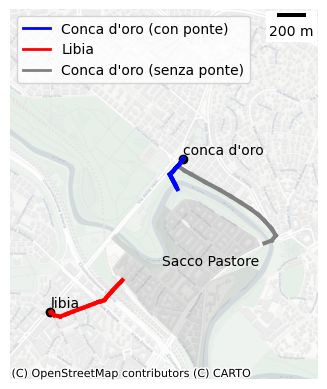

In [15]:
fig,axs=plt.subplots()
metros.plot(ax=axs,color="black")
for i,row in metros.iterrows():
    nome_metro="conca d'oro" if row["id_punto"].split("_")[1]=="concadoro" else "libia"
    axs.text(s=nome_metro,x=row["geometry"].x,y=row["geometry"].y*1.000007,color="black",fontweight="regular")


axs.set_xlim(xmin*0.9999,xmax*1.0001)
axs.set_ylim(ymin*0.99999,ymax*1.0001)

colors = {
"Sacco Pastore":"blue","conca d'oro":"#EFC69B"}

cmap = ListedColormap([t[1] for t in sorted(colors.items())]) #Sorting by keys before converting to list
colori=dict({'yesconcadoro':"blue", 'noconcadoro':"grey", 'yeslibia':"red", 'nolibia':"red"})

sezionimontesacro["Sacco Pastore"]="Sacco Pastore"
sezionimontesacro.loc[sezionimontesacro["SEZ2011"].isin(puntiaccesso["SEZ2011"])].plot(color="grey",legend=True,alpha=0.2,ax=axs)

# ponte=gdf.loc[gdf["id_punto"].apply(lambda x:x.split("_")[-1]).isin(punti_ponte)].copy()
# ponte.plot(color="blue",alpha=0.8,ax=axs)

# Create dummy lines for the legend
line_ponte = Line2D([0], [0], color='blue', linewidth=2, label="Conca d'oro (con ponte)")
line_percorso_libia = Line2D([0], [0], color='red', linewidth=2, label="Libia")
line_percorso_conca_doro = Line2D([0], [0], color='grey', linewidth=2, label="Conca d'oro (senza ponte)")

# Add the dummy lines to the legend
legend = axs.legend(handles=[line_ponte, line_percorso_libia, line_percorso_conca_doro], loc='upper left')

for un_punto in ["punto_accesso_93","punto_accesso_106"]:
    strada_da_selezionare=1 if un_punto=="punto_accesso_106" else 2
    for i,row in all_results.loc[all_results["puntoaccesso"]==un_punto].iloc[strada_da_selezionare:strada_da_selezionare+1].iterrows():
        shortest_path=eval(row["path"])
        if un_punto=="punto_accesso_106":
            shortest_path=shortest_path[6:]
        else:
            shortest_path=shortest_path[2:]
        shortest_path_to_plot = nx.get_node_attributes(G.subgraph(shortest_path), "pos")
        for i in range(0,len(shortest_path)-1):
            room1,room2=shortest_path[i],shortest_path[i+1]
            x1,y1=shortest_path_to_plot[room1]
            x2,y2=shortest_path_to_plot[room2]
            axs.plot([x1,x2],[y1,y2],linewidth=3,color=colori[row["tipo_tragitto"]])
            
for un_punto in ["punto_accesso_50"]:
    for i,row in all_results.loc[all_results["puntoaccesso"]==un_punto].iloc[0:1].iterrows():
        shortest_path=eval(row["path"])
        shortest_path=shortest_path[-20:]
        shortest_path_to_plot = nx.get_node_attributes(G.subgraph(shortest_path), "pos")
        for i in range(0,len(shortest_path)-1):
            room1,room2=shortest_path[i],shortest_path[i+1]
            x1,y1=shortest_path_to_plot[room1]
            x2,y2=shortest_path_to_plot[room2]
            axs.plot([x1,x2],[y1,y2],linewidth=3,color=colori[row["tipo_tragitto"]])
    

# axs.set_axis_off()
cx.add_basemap(axs, crs=gdf.crs, source=cx.providers.CartoDB.Positron)

# citation=axs.texts[-1]
# citation.remove()
# # Create the scale bar
scalebar = ScaleBar(1)  # 1 kilometer scale bar
# Add the scale bar to the plot
axs.add_artist(scalebar)

for row in sezionimontesacro.dissolve().centroid:
    axs.text(s="Sacco Pastore",x=row.x*0.99985,y=row.y,color="black",fontweight="regular")
    

axs.set_axis_off()
fig.savefig(f"{folder_progetto}figure\\figura1a.png",dpi=300)

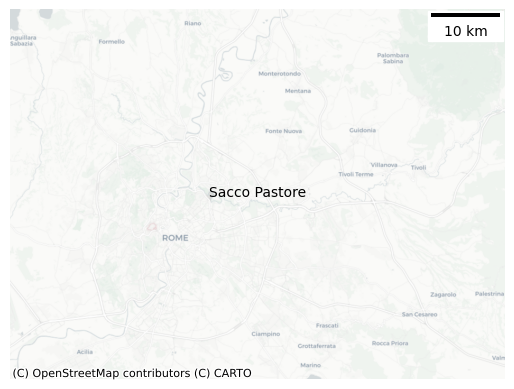

In [16]:
fig,axs=plt.subplots()

axs.set_xlim(xmin*0.98,xmax*1.03)
axs.set_ylim(ymin*0.995,ymax*1.005)

sezionimontesacro["Sacco Pastore"]="Sacco Pastore"
sezionimontesacro.plot(color="grey",legend=True,alpha=0.2,ax=axs)

# axs.set_axis_off()
cx.add_basemap(axs, crs=gdf.crs, source=cx.providers.CartoDB.Positron)

# citation=axs.texts[-1]
# citation.remove()
# # Create the scale bar
scalebar = ScaleBar(1)  # 1 kilometer scale bar
# Add the scale bar to the plot
axs.add_artist(scalebar)

for row in sezionimontesacro.dissolve().centroid:
    axs.text(s="Sacco Pastore",x=row.x*0.99985,y=row.y,color="black",fontweight="regular")    

axs.set_axis_off()
fig.savefig(f"{folder_progetto}figure\\figura1b.png",dpi=300)

## esempio di una distanza

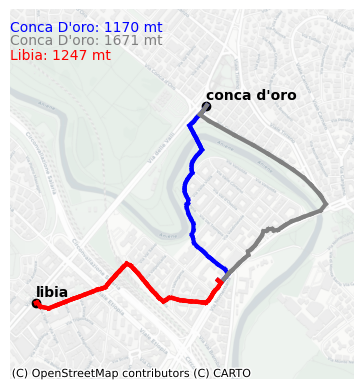

In [17]:
xmin,xmax,ymin,ymax=gdf.geometry.x.min(),gdf.geometry.x.max(),gdf.geometry.y.min(),gdf.geometry.y.max()

un_punto=all_results["puntoaccesso"].unique()[80]
# get list of coordinates
all_results.loc[all_results["puntoaccesso"]==un_punto]

colori=dict({"yesconcadoro":"blue","noconcadoro":"grey","yeslibia":"red","nolibia":"red"})
fig,axs=plt.subplots()



for i,row in all_results.loc[all_results["puntoaccesso"]==un_punto].iterrows():
    shortest_path=eval(row["path"])
    shortest_path_to_plot = nx.get_node_attributes(G.subgraph(shortest_path), "pos")
    for i in range(0,len(shortest_path)-1):
        room1,room2=shortest_path[i],shortest_path[i+1]
        x1,y1=shortest_path_to_plot[room1]
        x2,y2=shortest_path_to_plot[room2]
        axs.plot([x1,x2],[y1,y2],linewidth=3,color=colori[row["tipo_tragitto"]])
    

risultati=all_results.loc[all_results["puntoaccesso"]==un_punto]
one="Conca D'oro: {0} mt\n".format(int(risultati.iloc[0]["distance"]))
two="Conca D'oro: {0} mt\n".format(int(risultati.iloc[1]["distance"]))
three="Libia: {0} mt".format(int(risultati.iloc[2]["distance"]))

metros.plot(ax=axs,color="black")
for i,row in metros.iterrows():
    nome_metro="conca d'oro" if row["id_punto"].split("_")[1]=="concadoro" else "libia"
    axs.text(s=nome_metro,x=row["geometry"].x,y=row["geometry"].y*1.000007,color="black",fontweight="bold")

axs.set_xlim(xmin*0.9999,xmax*1.0001)
axs.set_ylim(ymin*0.99999,ymax*1.0001)


axs.text(s=one,x=xmin*0.9999,y=ymax*1.00006,color="blue")
axs.text(s=two,x=xmin*0.9999,y=ymax*1.00006-70,color="grey")
axs.text(s=three,x=xmin*0.9999,y=ymax*1.00006-60,color="red")

# axs.set_axis_off()
cx.add_basemap(axs, crs=gdf.crs, source=cx.providers.CartoDB.Positron)
axs.set_axis_off()

In [18]:
risultati=all_results.loc[all_results["puntoaccesso"]==un_punto]

In [19]:
analisi=all_results.pivot(index="puntoaccesso",columns="tipo_tragitto",values="distance").reset_index()
analisi["shortest_con_ponte"]=analisi[["noconcadoro","yesconcadoro","yeslibia"]].apply(lambda x:min(x),axis=1)
analisi["shortest_senza_ponte"]=analisi[["noconcadoro","yeslibia"]].apply(lambda x:min(x),axis=1)
analisi["miglioramento"]=analisi["shortest_con_ponte"]-analisi["shortest_senza_ponte"]

analisi=pd.merge(puntiaccesso[["geometry","id_punto"]],
    analisi.rename({"puntoaccesso":"id_punto"},axis=1))

def convert_distance_to_time(distance_meters, walking_speed_kph):
    # Convert walking speed to meters per minute
    walking_speed_mpm = walking_speed_kph * 1000 / 60

    # Calculate time in minutes
    time_minutes = distance_meters / walking_speed_mpm

    return time_minutes
analisi["miglioramento_minuti"]=analisi["miglioramento"].apply(lambda x:convert_distance_to_time(x,4))
analisi["shortest_con_ponte_minuti"]=analisi["shortest_con_ponte"].apply(lambda x:convert_distance_to_time(x,4))
analisi["shortest_senza_ponte_minuti"]=analisi["shortest_senza_ponte"].apply(lambda x:convert_distance_to_time(x,4))

In [20]:
def return_closer_metro(x,mode="con"):
    posizione=list(x).index(min(x))
    if mode=="con":        
        if posizione==1:
            y="libia"
        else:
            y="conca d'oro"
        return y
    else:
        if posizione==0:
            y="conca d'oro"
        else:
            y="libia"
        return y

### con i palazzi...

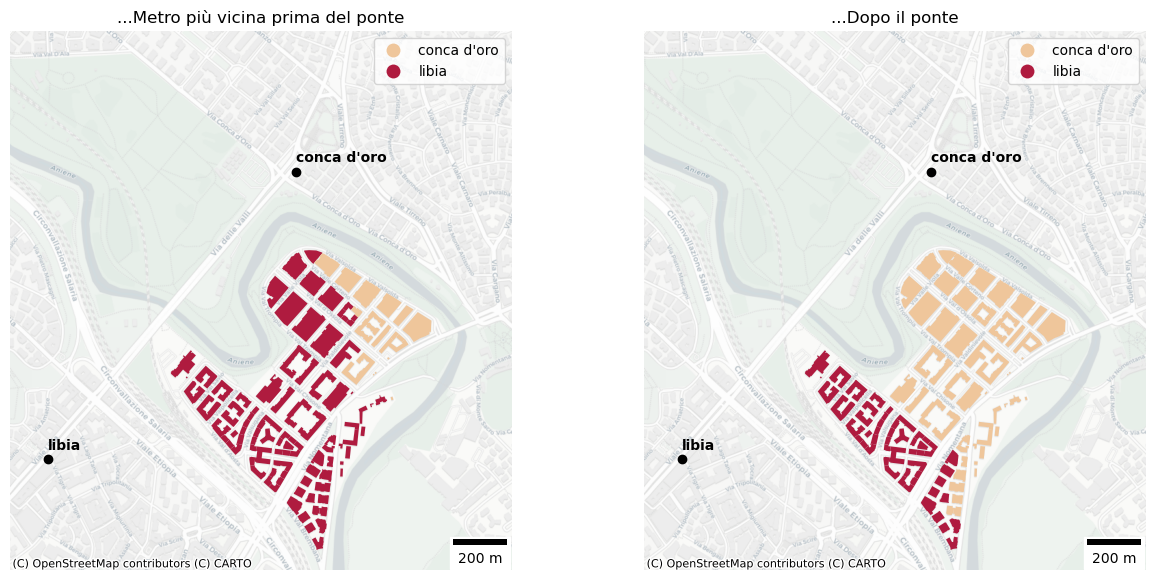

In [21]:

colors = {
"libia":"#AF1B3F","conca d'oro":"#EFC69B"}

cmap = ListedColormap([t[1] for t in sorted(colors.items())]) #Sorting by keys before converting to list
analisi["metro_piu_vicina_con"]=analisi.iloc[:,2:6].apply(lambda x:return_closer_metro(x,mode="con"),axis=1)
analisi["metro_piu_vicina_senza"]=analisi.iloc[:,2:4].apply(lambda x:return_closer_metro(x,mode="senza"),axis=1)

## riconduci l'analisi alle geometries di palazzi...
analisi2=pd.merge(palazzi[["id_palazzo","geometry"]].to_crs("EPSG:3857"),
        pd.merge(analisi.drop("geometry",axis=1),puntiaccesso[["id_punto","id_palazzo"]]))


## imposta e visualizza la figura
fig,axs=plt.subplots(figsize=(15,7),ncols=2)

analisi2.plot("metro_piu_vicina_senza",cmap=cmap,legend=True,ax=axs[0])
axs[0].set_xlim(xmin*0.9999,xmax*1.0001)
axs[0].set_ylim(ymin*0.99999,ymax*1.0001)
# axs.set_axis_off()
cx.add_basemap(axs[0], crs=gdf.crs, source=cx.providers.CartoDB.Positron)
axs[0].set_title("...Metro più vicina prima del ponte")
axs[0].set_axis_off()

analisi2.plot("metro_piu_vicina_con",cmap=cmap,legend=True,ax=axs[1])
axs[1].set_xlim(xmin*0.9999,xmax*1.0001)
axs[1].set_ylim(ymin*0.99999,ymax*1.0001)
# axs.set_axis_off()
cx.add_basemap(axs[1], crs=gdf.crs, source=cx.providers.CartoDB.Positron)
axs[1].set_title("...Dopo il ponte")
axs[1].set_axis_off()


for r in [axs[0],axs[1]]:
    metros.plot(ax=r,color="black")
    for i,row in metros.iterrows():
        nome_metro="conca d'oro" if row["id_punto"].split("_")[1]=="concadoro" else "libia"
        r.text(s=nome_metro,x=row["geometry"].x,y=row["geometry"].y*1.000007,color="black",fontweight="bold")
    scalebar = ScaleBar(1,location="lower right")  # 1 kilometer scale bar
    r.add_artist(scalebar)
# Add the scale bar to the plot
fig.savefig(f"{folder_progetto}figure\\figura2.png",dpi=300)

## analisi medie e distribuzione

In [22]:
import numpy as np

In [23]:
analisi_tempi=pd.merge(analisi,puntiaccesso[["poppunto","id_punto"]])

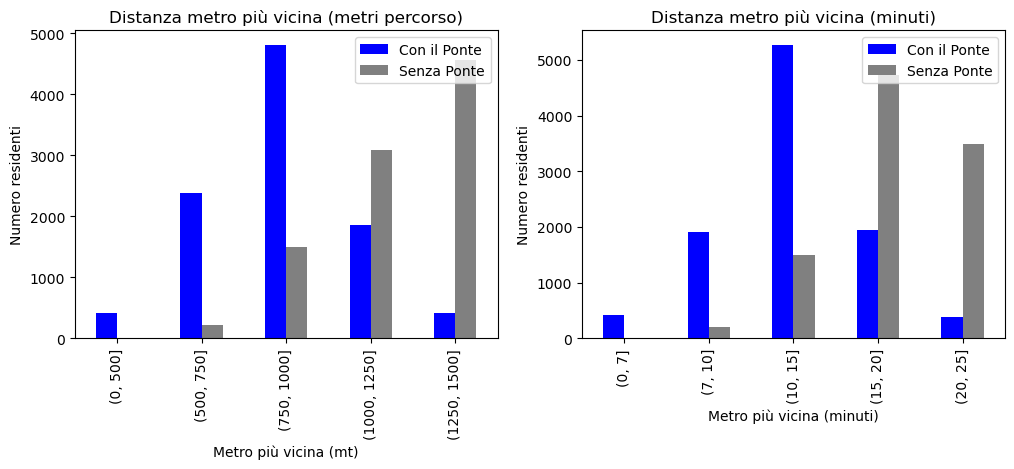

In [24]:
fig,axs=plt.subplots(figsize=(12,4),ncols=2)


var="shortest_con_ponte"
analisi_tempi[var+"_binned"]=pd.cut(analisi_tempi[var],bins=[0,500,750,1000,1250,1500])
dplot=pd.DataFrame(analisi_tempi.groupby(var+"_binned")["poppunto"].sum()).rename({"poppunto":var},axis=1).reset_index().rename({var+"_binned":"indice"},axis=1)

var="shortest_senza_ponte"
analisi_tempi[var+"_binned"]=pd.cut(analisi_tempi[var],bins=[0,500,750,1000,1250,1500])
dplot=pd.merge(dplot,
         pd.DataFrame(analisi_tempi.groupby(var+"_binned")["poppunto"].sum()).rename({"poppunto":var},axis=1).reset_index().rename({var+"_binned":"indice"},axis=1))
dplot.plot(x='indice', kind='bar', stacked=False,ax=axs[0],color=["blue","grey"])
# Add labels and title
axs[0].set_xlabel('Metro più vicina (mt)')
axs[0].set_ylabel('Numero residenti')
axs[0].set_title('Distanza metro più vicina (metri percorso)')
# Add legend
axs[0].legend(['Con il Ponte', 'Senza Ponte'], loc='upper right')


var="shortest_con_ponte_minuti"
analisi_tempi[var+"_binned"]=pd.cut(analisi_tempi[var],bins=[0,7,10,15,20,25])
dplot=pd.DataFrame(analisi_tempi.groupby(var+"_binned")["poppunto"].sum()).rename({"poppunto":var},axis=1).reset_index().rename({var+"_binned":"indice"},axis=1)

var="shortest_senza_ponte_minuti"
analisi_tempi[var+"_binned"]=pd.cut(analisi_tempi[var],bins=[0,7,10,15,20,25])
dplot=pd.merge(dplot,
         pd.DataFrame(analisi_tempi.groupby(var+"_binned")["poppunto"].sum()).rename({"poppunto":var},axis=1).reset_index().rename({var+"_binned":"indice"},axis=1))

dplot.plot(x='indice', kind='bar', stacked=False,ax=axs[1],color=["blue","grey"])
# Add labels and title
axs[1].set_xlabel('Metro più vicina (minuti)')
axs[1].set_ylabel('Numero residenti')
axs[1].set_title('Distanza metro più vicina (minuti)')

# Add legend
axs[1].legend(['Con il Ponte', 'Senza Ponte'], loc='upper right')
fig.savefig(f"{folder_progetto}figure\\figura3.png",dpi=300,bbox_inches="tight")

In [25]:
print("percentuale entro i 10 minuti senza ponte")
print(dplot["shortest_senza_ponte_minuti"].iloc[0:3].sum()/dplot["shortest_con_ponte_minuti"].sum())

print("percentuale entro i 10 minuti con ponte")
print(dplot["shortest_con_ponte_minuti"].iloc[0:3].sum()/dplot["shortest_con_ponte_minuti"].sum())
print("media distanza con ponte")
print(np.average(analisi_tempi["shortest_con_ponte"], weights=analisi_tempi["poppunto"]))
print("media distanza senza ponte")
print(np.average(analisi_tempi["shortest_senza_ponte"], weights=analisi_tempi["poppunto"]))

print("media minuti con ponte")
print(np.average(analisi_tempi["shortest_con_ponte_minuti"], weights=analisi_tempi["poppunto"]))
print("media minuti senza ponte")
print(np.average(analisi_tempi["shortest_senza_ponte_minuti"], weights=analisi_tempi["poppunto"]))

percentuale entro i 10 minuti senza ponte
0.1731039923278009
percentuale entro i 10 minuti con ponte
0.7652851036623408
media distanza con ponte
856.0647915628032
media distanza senza ponte
1219.6039644958653
media minuti con ponte
12.840971873442045
media minuti senza ponte
18.294059467437982


In [26]:
### seleziona chi ci guadagna
beneficiari=analisi_tempi.loc[analisi_tempi["shortest_con_ponte"]<analisi_tempi["shortest_senza_ponte"]]
print("totale beneficiari")
print(beneficiari["poppunto"].sum())
print("totale beneficiari %")
print(beneficiari["poppunto"].sum()/analisi_tempi["poppunto"].sum())
print("tempo medio prima del ponte")
print(np.average(beneficiari["shortest_senza_ponte_minuti"], weights=beneficiari["poppunto"]))
print("tempo medio dopo il ponte")
print(np.average(beneficiari["shortest_con_ponte_minuti"], weights=beneficiari["poppunto"]))
print("guadagno medio")
print(np.average(beneficiari["shortest_con_ponte_minuti"]-beneficiari["shortest_senza_ponte_minuti"], weights=beneficiari["poppunto"]))

totale beneficiari
6879.266666666666
totale beneficiari %
0.6916616395200751
tempo medio prima del ponte
20.032645855731463
tempo medio dopo il ponte
12.148606489633787
guadagno medio
-7.884039366097681


In [27]:
print("Passeggeri giornalieri Jonio")
## 2 milioni e 200 milina passeggeri giornalieri
print(2200000/365)

Passeggeri giornalieri Jonio
6027.397260273972


In [28]:
print("costo medio jonio (costo/passeggeri)")
print(220000000/6504)

print("costo medio ponte (costo/passeggeri)")
print(3500000/300)

costo medio jonio (costo/passeggeri)
33825.338253382535
costo medio ponte (costo/passeggeri)
11666.666666666666


In [29]:
puntiaccesso["abitazionipunto"]=puntiaccesso["TOTALE_ABITAZIONI"]/puntiaccesso["numeropuntisezione"]

In [30]:
totale_abitazioni_beneficiarie=puntiaccesso.loc[puntiaccesso["id_punto"].isin(beneficiari["id_punto"]),"abitazionipunto"].sum()
valore_prezzo_medio=250000

In [31]:
totale_abitazioni_beneficiarie

3675.6666666666665

In [32]:
(totale_abitazioni_beneficiarie*valore_prezzo_medio*0.10)/1000000

91.89166666666667

## mappe miglioramento

In [33]:
from matplotlib.colors import Normalize

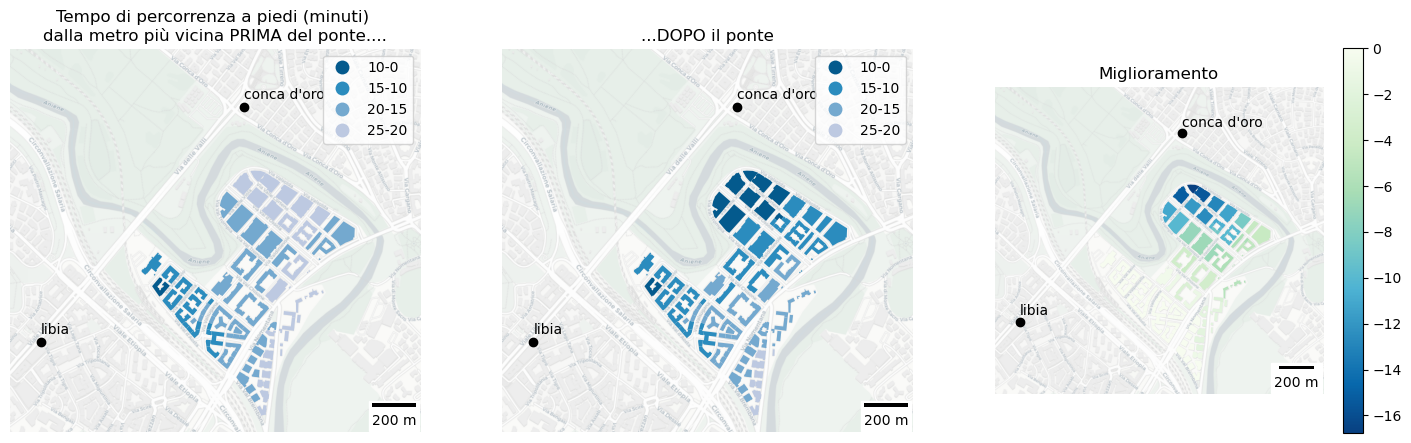

In [34]:
## riconduci l'analisi alle geometries di palazzi...
analisi2=pd.merge(palazzi[["id_palazzo","geometry"]].to_crs("EPSG:3857"),
        pd.merge(analisi.drop("geometry",axis=1),puntiaccesso[["id_punto","id_palazzo"]]))

#colors = {"+20":'#f1eef6',"15-20":'#bdc9e1',"10-15":'#74a9cf', "7-10":'#0570b0',"0-7":'#0570b0'}

colori=['#f1eef6','#bdc9e1','#74a9cf','#2b8cbe','#045a8d']
#colori=['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']
#colori=['#f7f7f7','#cccccc','#969696','#636363','#252525']
colori.reverse()
#colori=["red","blue","green","yellow","black"]
labelz=dict({'(20, 25]':"25-20", '(15, 20]':"20-15", '(10, 15]':"15-10", '(0, 10]':"10-0"})
colors=dict(zip(['25-20', '20-15', '15-10', '10-0'],colori))

cmap = ListedColormap(colors.values())

for var in ["shortest_senza_ponte_minuti","shortest_con_ponte_minuti"]:
    analisi2[var+"_binned"]=pd.cut(analisi2[var],bins=[0,10,15,20,25])
    analisi2[var+"_binned"]=analisi2[var+"_binned"].apply(lambda x:str(x)).astype(str)
    analisi2[var+"_binned"]=analisi2[var+"_binned"].replace(labelz)
    analisi2[var+"_binned_color"]=analisi2[var+"_binned"].replace(colors)


fig,axs=plt.subplots(figsize=(18,5),ncols=3)

analisi2.plot("shortest_senza_ponte_minuti_binned",cmap=cmap,legend=True,ax=axs[0])
axs[0].set_xlim(xmin*0.9999,xmax*1.0001)
axs[0].set_ylim(ymin*0.99999,ymax*1.00005)
# axs.set_axis_off()
cx.add_basemap(axs[0], crs=gdf.crs, source=cx.providers.CartoDB.Positron)
axs[0].set_title("Tempo di percorrenza a piedi (minuti) \ndalla metro più vicina PRIMA del ponte....")
axs[0].set_axis_off()

analisi2.plot("shortest_con_ponte_minuti_binned",cmap=cmap,legend=True,ax=axs[1])
axs[1].set_xlim(xmin*0.9999,xmax*1.0001)
axs[1].set_ylim(ymin*0.99999,ymax*1.00005)
# axs.set_axis_off()
cx.add_basemap(axs[1], crs=gdf.crs, source=cx.providers.CartoDB.Positron)
axs[1].set_title("...DOPO il ponte")
axs[1].set_axis_off()


analisi2.plot("miglioramento_minuti",cmap="GnBu_r",legend=True,ax=axs[2],legend_kwds={'shrink': 1})
axs[2].set_xlim(xmin*0.9999,xmax*1.0001)
axs[2].set_ylim(ymin*0.99999,ymax*1.00005)
# axs.set_axis_off()
cx.add_basemap(axs[2], crs=gdf.crs, source=cx.providers.CartoDB.Positron)
axs[2].set_title("Miglioramento")
axs[2].set_axis_off()

for r in [axs[0],axs[1],axs[2]]:
    metros.plot(ax=r,color="black")
    for i,row in metros.iterrows():
        nome_metro="conca d'oro" if row["id_punto"].split("_")[1]=="concadoro" else "libia"
        r.text(s=nome_metro,x=row["geometry"].x,y=row["geometry"].y*1.000007,color="black")
    ### remove stamen toner citation
    citation=r.texts[0]
    citation.remove()
    # Create the scale bar
    scalebar = ScaleBar(1,location="lower right")  # 1 kilometer scale bar
    # Add the scale bar to the plot
    r.add_artist(scalebar)
        
fig.savefig(f"{folder_progetto}figure\\figura4.png",dpi=300,bbox_inches="tight")

### folium buildings

In [35]:
import folium


import branca
from branca.element import MacroElement

from jinja2 import Template


class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """
    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """)  # noqa

In [36]:
dplot=pd.merge(analisi2,puntiaccesso[["id_punto","poppunto"]])
dplot["poppunto"]=dplot["poppunto"].apply(lambda x:int(x))
dplot.to_crs("EPSG:4326",inplace=True)

dplot.rename({"miglioramento_minuti":"Riduzione minuti",
              "miglioramento":"Riduzione distanza (mt)","poppunto":"Popolazione",
             "shortest_con_ponte":"Distanza con ponte (mt)","shortest_con_ponte_minuti":"Distanza con ponte (minuti)",
              "shortest_senza_ponte_minuti":"Distanza senza ponte (minuti)","shortest_senza_ponte":"Distanza senza ponte (mt)"},axis=1,inplace=True)

In [37]:
per_tooltip=["Popolazione","Riduzione minuti","Riduzione distanza (mt)",
             "Distanza con ponte (mt)","Distanza senza ponte (mt)","Distanza senza ponte (minuti)","Distanza con ponte (minuti)"]

In [38]:
dplot.loc[:,per_tooltip]=dplot.loc[:,per_tooltip].round(0)

## folium

In [40]:
keyvar="id_punto"
m = folium.Map(location=[41.93446547979569, 12.52766620754331], 
               tiles="cartodbpositron",
               zoom_start=15)

for var in [per_tooltip[1]]:
    
    
    choropleth=folium.Choropleth(
        geo_data=dplot.to_json(),
        name=str(var),
        data=dplot,
        key_on=str("feature.properties.")+str(keyvar),
        fill_color="viridis",
        fill_opacity=0.5,
        line_opacity=0.2,
        bins=10,
        columns=[keyvar,var],## mostra solo l'ultimo
        style=("font-family: Clincher Mono Web"),show=True)
    choropleth.add_to(m)
    choropleth.geojson.add_child(folium.features.GeoJsonTooltip(per_tooltip,style=("font-family: Clincher Mono Web")))
    
folium.LayerControl(collapsed=False).add_to(m)
m.save(f"{folder_progetto}mappa_interattiva_ponte.html")
m

### with folium

In [371]:
# m = folium.Map(location=[41.93446547979569, 12.52766620754331], 
#                tiles="cartodbpositron",
#                zoom_start=15)
# una_strada=all_results.loc[all_results["puntoaccesso"]==unpunto].iloc[0]
# dic_ponte=dict({"yes":"red","no":"blue"})
# for i,una_strada in all_results.loc[(all_results["metro"]=="concadoro")&(all_results["puntoaccesso"]==unpunto)].iterrows():

#     trail_coordinates=[(x.y,x.x) for x in g_info.set_index("punto").loc[eval(una_strada["path"]),"geometry"].values]
#     folium.PolyLine(trail_coordinates, color=dic_ponte[una_strada["conponte"]],
#                     tooltip=una_strada["conponte"]).add_to(m)
# m

### retrieve building

In [373]:
analisi

,geometry,id_punto,noconcadoro,nolibia,yesconcadoro,yeslibia,shortest_con_ponte,shortest_senza_ponte,miglioramento,miglioramento_minuti,metro_piu_vicina_con,metro_piu_vicina_senza
0,POINT (1394719.194 5150992.305),punto_accesso_0,1551.441694,1363.635069,1126.743619,1363.635069,1126.743619,1363.635069,-236.891450,-7.106744,conca d'oro,libia
1,POINT (1394663.924 5151039.756),punto_accesso_1,1667.664525,1225.278543,985.276039,1225.278543,985.276039,1225.278543,-240.002504,-7.200075,conca d'oro,libia
2,POINT (1394777.554 5151006.461),punto_accesso_2,1477.759481,1385.573515,1053.061406,1385.573515,1053.061406,1385.573515,-332.512109,-9.975363,conca d'oro,libia
3,POINT (1394751.807 5151279.521),punto_accesso_3,1491.543664,1334.152169,748.807092,1334.152169,748.807092,1334.152169,-585.345077,-17.560352,conca d'oro,libia
4,POINT (1394762.687 5151323.863),punto_accesso_4,1483.862955,1373.711032,647.546736,1373.711032,647.546736,1373.711032,-726.164295,-21.784929,conca d'oro,libia
...,...,...,...,...,...,...,...,...,...,...,...,...
107,POINT (1394912.378 5151328.691),punto_accesso_107,1349.743702,1552.037751,785.743678,1552.037751,785.743678,1349.743702,-564.000023,-16.920001,conca d'oro,conca d'oro
108,POINT (1394964.708 5151291.052),punto_accesso_108,1206.593573,1655.553886,906.826949,1655.553886,906.826949,1206.593573,-299.766623,-8.992999,conca d'oro,conca d'oro
109,POINT (1394631.919 5151410.103),punto_accesso_109,1690.116822,1389.184976,594.870241,1389.184976,594.870241,1389.184976,-794.314735,-23.829442,conca d'oro,libia
110,POINT (1394762.416 5151423.152),punto_accesso_110,1463.344159,1549.869550,599.983331,1549.869550,599.983331,1463.344159,-863.360828,-25.900825,conca d'oro,conca d'oro


In [372]:
palazzi

,geometry,id_punto
0,"MULTIPOLYGON (((12.52657 41.92906, 12.52666 41...",0
1,"MULTIPOLYGON (((12.52273 41.94256, 12.52273 41...",1
2,"MULTIPOLYGON (((12.51880 41.93060, 12.51939 41...",2
3,"MULTIPOLYGON (((12.52356 41.93304, 12.52374 41...",3
4,"MULTIPOLYGON (((12.52341 41.93339, 12.52346 41...",4
...,...,...
815,"MULTIPOLYGON (((12.53278 41.94037, 12.53252 41...",815
816,"MULTIPOLYGON (((12.53425 41.94200, 12.53422 41...",816
817,"MULTIPOLYGON (((12.53348 41.94068, 12.53354 41...",817
818,"MULTIPOLYGON (((12.53444 41.93859, 12.53442 41...",818


<AxesSubplot:>

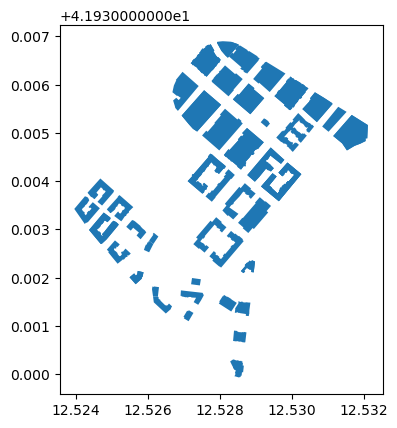

In [257]:
analisi2=palazzi.sjoin(analisi.to_crs("EPSG:4326"))
analisi2.plot()

In [283]:
analisipersezione=pd.merge(pd.merge(sezionimontesacro[["SEZ2011","geometry"]],puntiaccesso[["id_punto","SEZ2011"]]),
analisi.drop("geometry",axis=1))

analisi2=palazzi.to_crs("EPSG:3857").sjoin(analisipersezione)

In [287]:

colors = {
"libia":"#AF1B3F","conca d'oro":"#EFC69B"}

cmap = ListedColormap([t[1] for t in sorted(colors.items())]) #Sorting by keys before converting to list
analisi["metro_piu_vicina_con"]=analisi.iloc[:,2:6].apply(lambda x:return_closer_metro(x,mode="con"),axis=1)
analisi["metro_piu_vicina_senza"]=analisi.iloc[:,2:4].apply(lambda x:return_closer_metro(x,mode="senza"),axis=1)

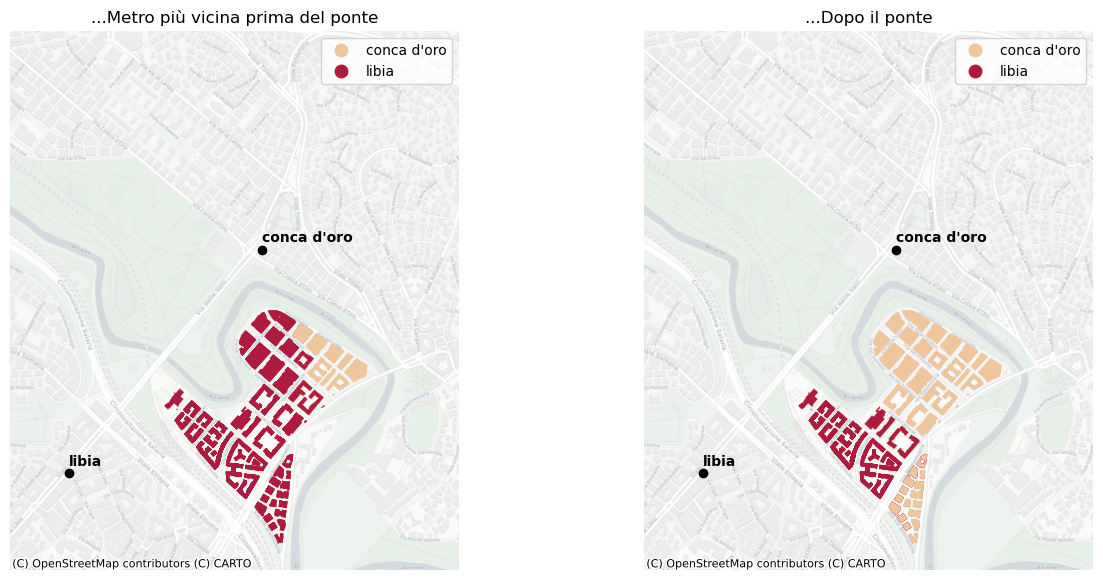

In [289]:
fig,axs=plt.subplots(figsize=(15,7),ncols=2)

analisi2.plot("metro_piu_vicina_senza",cmap=cmap,legend=True,ax=axs[0])
axs[0].set_xlim(xmin*0.9999,xmax*1.0001)
axs[0].set_ylim(ymin*0.99999,ymax*1.0001)
# axs.set_axis_off()
cx.add_basemap(axs[0], crs=gdf.crs, source=cx.providers.CartoDB.Positron)
axs[0].set_title("...Metro più vicina prima del ponte")
axs[0].set_axis_off()

analisi2.plot("metro_piu_vicina_con",cmap=cmap,legend=True,ax=axs[1])
axs[1].set_xlim(xmin*0.9999,xmax*1.0001)
axs[1].set_ylim(ymin*0.99999,ymax*1.0001)
# axs.set_axis_off()
cx.add_basemap(axs[1], crs=gdf.crs, source=cx.providers.CartoDB.Positron)
axs[1].set_title("...Dopo il ponte")
axs[1].set_axis_off()

for r in [axs[0],axs[1]]:
    metros.plot(ax=r,color="black")
    for i,row in metros.iterrows():
        nome_metro="conca d'oro" if row["id_punto"].split("_")[1]=="concadoro" else "libia"
        r.text(s=nome_metro,x=row["geometry"].x,y=row["geometry"].y*1.000007,color="black",fontweight="bold")

In [292]:
analisi2

,geometry,index_right,SEZ2011,id_punto,noconcadoro,nolibia,yesconcadoro,yeslibia,shortest_con_ponte,shortest_senza_ponte,miglioramento,miglioramento_minuti,metro_piu_vicina_con,metro_piu_vicina_senza
10,"MULTIPOLYGON (((1394698.556 5150937.508, 13947...",77,580912160222,punto_accesso_58,1480.223470,1350.099897,998.713784,1350.099897,998.713784,1350.099897,-351.386113,-10.541583,conca d'oro,libia
219,"MULTIPOLYGON (((1394721.399 5151060.017, 13947...",77,580912160222,punto_accesso_58,1480.223470,1350.099897,998.713784,1350.099897,998.713784,1350.099897,-351.386113,-10.541583,conca d'oro,libia
673,"MULTIPOLYGON (((1394772.116 5151004.247, 13947...",77,580912160222,punto_accesso_58,1480.223470,1350.099897,998.713784,1350.099897,998.713784,1350.099897,-351.386113,-10.541583,conca d'oro,libia
10,"MULTIPOLYGON (((1394698.556 5150937.508, 13947...",73,580912160222,punto_accesso_54,1512.647121,1353.351570,1087.949046,1353.351570,1087.949046,1353.351570,-265.402524,-7.962076,conca d'oro,libia
219,"MULTIPOLYGON (((1394721.399 5151060.017, 13947...",73,580912160222,punto_accesso_54,1512.647121,1353.351570,1087.949046,1353.351570,1087.949046,1353.351570,-265.402524,-7.962076,conca d'oro,libia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,"MULTIPOLYGON (((1394754.127 5151468.601, 13948...",120,580912160189,punto_accesso_110,1408.298947,1459.947991,669.284339,1459.947991,669.284339,1408.298947,-739.014608,-22.170438,conca d'oro,conca d'oro
751,"MULTIPOLYGON (((1394829.602 5151422.570, 13948...",46,580912160193,punto_accesso_125,1342.149136,1506.854763,656.408231,1506.854763,656.408231,1342.149136,-685.740905,-20.572227,conca d'oro,conca d'oro
751,"MULTIPOLYGON (((1394829.602 5151422.570, 13948...",43,580912160193,punto_accesso_122,1336.534713,1522.965042,769.119596,1522.965042,769.119596,1336.534713,-567.415117,-17.022454,conca d'oro,conca d'oro
751,"MULTIPOLYGON (((1394829.602 5151422.570, 13948...",44,580912160193,punto_accesso_123,1418.371069,1430.825126,667.213449,1430.825126,667.213449,1418.371069,-751.157620,-22.534729,conca d'oro,conca d'oro
